# New York Bike Share Business and Implementation Plan


### Name: Pei-Yu Lan

We are planning to enter NYC market but we don't have any bike share related data. <br>
We are trying to estimate the market volume/demand<br><br>
Our solution is to leverage NYC taxi pick up and dropoff data.<br>
Demand comes from resource scarcity and substitution effect: <br>
In other words, consider what if taxi is not available or too expensive?

* **High ride cost:**<br>
Convert short-distance taxi rider to bike rider 
* **High taxi demand but short taxi supply:**<br>
fill the gap with bike: (taxi demand - supply)<br>
* **When traffic is bad and trip distance is short**<br><br>
Assumption:

* **Distance range**<br>
20-30 mins ride time, about 5 miles
* **Each user has only one ride**


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Part 1: Data Exploration


### Part 1.1: Understand the Raw Dataset

In [2]:
# read data from local drive using Jupyter notebook mode
df=pd.read_csv('nyc_yellow_trip_201210_sample_processed.csv',sep=',')


In [3]:
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount
0,2012-10-01 07:57:14,2012-10-01 08:07:03,1,1.70,-73.993948,40.751194,-73.972795,40.755737,CRD,2.25,11.25
1,2012-10-01 07:57:55,2012-10-01 08:01:37,3,0.40,-73.978451,40.759869,-73.987742,40.751957,CSH,0.00,5.00
2,2012-10-01 07:57:00,2012-10-01 08:06:00,1,1.19,-73.954290,40.784127,-73.966245,40.789810,CRD,1.00,9.50
3,2012-10-01 07:57:00,2012-10-01 08:18:00,1,3.22,-73.939198,40.791792,-73.972487,40.760687,CRD,1.00,17.00
4,2012-10-01 07:57:27,2012-10-01 08:02:14,1,0.80,-73.960658,40.769850,-73.968667,40.764806,CRD,1.20,7.20


In [4]:
print ("Num of rows: " + str(df.shape[0])) # row count
print ("Num of columns: " + str(df.shape[1]))

Num of rows: 1452231
Num of columns: 11


### Part 1.2: Data cleaning (using domain knowledge)

* **Remove outliers:**<br>
by trip_distance( <=0.15 mile ) <br>
by coordinate/geographical data (outside NYC) <br>

* **Remove NA**



In [5]:
# remove trip_distance<=0.15
df.drop(df[df['trip_distance']<=0.15].index, inplace=True)
# remove null value
df.dropna(inplace=True)

# remove locations not in New York City : (40.705542,-74.018415), (40.851476, -73.884222)
df=df[(df['pickup_latitude'] >= 40.705542) & (df['pickup_latitude']<= 40.851476)\
               &(df['pickup_longitude']>=-74.018415) & (df['pickup_longitude'] <=-73.884222)]

df.index=np.arange(df.shape[0])

In [6]:
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,tip_amount,total_amount
0,2012-10-01 07:57:14,2012-10-01 08:07:03,1,1.70,-73.993948,40.751194,-73.972795,40.755737,CRD,2.25,11.25
1,2012-10-01 07:57:55,2012-10-01 08:01:37,3,0.40,-73.978451,40.759869,-73.987742,40.751957,CSH,0.00,5.00
2,2012-10-01 07:57:00,2012-10-01 08:06:00,1,1.19,-73.954290,40.784127,-73.966245,40.789810,CRD,1.00,9.50
3,2012-10-01 07:57:00,2012-10-01 08:18:00,1,3.22,-73.939198,40.791792,-73.972487,40.760687,CRD,1.00,17.00
4,2012-10-01 07:57:27,2012-10-01 08:02:14,1,0.80,-73.960658,40.769850,-73.968667,40.764806,CRD,1.20,7.20


# Part 2: Exploratory Analysis

### Part 2.1 Distribution: distance
In order to get suitable trips for bike

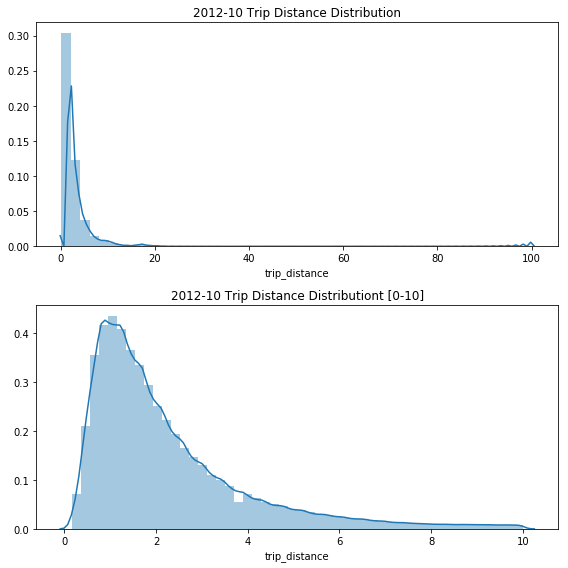

In [7]:
# Trip distance Distribution
fig=plt.figure(figsize=(8,8))
ax0=fig.add_subplot(2,1,1)
sns.distplot(df.trip_distance)
ax0.set_title('2012-10 Trip Distance Distribution')

# ax1=fig.add_subplot(3,1,2)
# sns.distplot(df.trip_distance,
#              hist_kws=dict(cumulative=True),
#              kde_kws=dict(cumulative=True),
#              ax=ax1)
# ax1.set_ylabel('Cumulative percentage')
# ax1.set_title('2012 Trip Distance Cumulative Dist')

# cumulative distributio of trip distance
ax2=fig.add_subplot(2,1,2)
sns.distplot(df['trip_distance'][df['trip_distance']<=10])
ax2.set_title('2012-10 Trip Distance Distributiont [0-10]')

plt.tight_layout()

* **We're going to find the distance within 20mins bike, approximately 5 miles.**

In [8]:
trip_sort=np.sort(df['trip_distance'])
# trip_cumu_sort=np.cumsum(np.sort(df['trip_distance']))/df['trip_distance'].sum()
# trip_sort[np.min(np.where(trip_cumu_sort>=0.8))] # 8 miles needs 30mins
# #8.099999999999998

# 65% of rides are within 20 mins bike distance, 1,237,439 rides in 201210
trip_sort[np.where(trip_sort<=5)].shape[0]/df.shape[0]


0.8968459529788895

89.7% of rides are within 20 mins bike distance, 1,184,564 rides in Oct, 2010.

### Part 2.2: Narrow Down Distance and Remove Location Outliers

In [9]:
df_5_mi=df.loc[df['trip_distance']<=5,:]
df_5_mi.index=np.arange(df_5_mi.shape[0])

In [10]:
df_5_mi.shape

(1184564, 11)

* **There are 1,184,564 rides within 5 miles, and we are going to analyze it whether these riders are our potential customers.**

### Part 2.3: Coordinate Data Visualization: Use pickup as an example

We are going to randomly choose 10,000 from dataset 'df_5_mi' since the the data is too large to show up on the map. Besides, we're interested what the distribution of the rides in NYC.

In [11]:
# Google Map Visualization
# random sampled 10,000 rows from df_5_mi
np.random.seed(50)
loc_pickup_sample_index=np.random.choice(df_5_mi.shape[0],10000,replace=False)
loc_pickup_total=df_5_mi.loc[loc_pickup_sample_index]
loc_pickup=loc_pickup_total[['pickup_latitude','pickup_longitude']]
loc_pickup.columns=['latitude','longitude']
loc_pickup.index=np.arange(loc_pickup.shape[0])


In [12]:
loc_pickup.head()

,latitude,longitude
0,40.732462,-73.990207
1,40.758873,-73.991663
2,40.725450,-73.996342
3,40.738646,-73.983286
4,40.759542,-73.984508


In [13]:
# pickup location is uniformly distributed
import gmaps
import gmaps.datasets
gmaps.configure(api_key='')
new_york_coordinates = (40.75, -74.00)
fig=gmaps.figure(center=new_york_coordinates, zoom_level=12)
fig.add_layer(gmaps.heatmap_layer(loc_pickup))
fig

Figure(layout=FigureLayout(height='420px'))

# Taxi Supply and Demand Delta
Find popular spots that have substantial amount of supply and demand gap.

# Ride Clustering
find popular pick up locations that have X minimum pickups with Y maximum distance from each other.
Popular clustering algorithms: kmeans family, DBSCAN.
Kmeans is likely the most common clustering algorithm but not good for spatial data. It's not easy to know ahead the number of K. DBSCAN seems to correspond more to human intuitions of clustering: minimum number of points in a cluster, maximum distance from each other. 



In [16]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [43]:
# DBSCAN clustering, return cluster centroid and number of points
# for DBSCAN, points can't be clustered will be categorized as 0_cluster
def dbscan_clustering(max_distance,min_sample,ride_data):
    ## Data extraction
    coords=ride_data.as_matrix(columns=['latitude', 'longitude'])
    ## model parameters
    # the earth mean radius is 6,371.0088 km 
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    db = DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    cluster_labels = db.labels_   
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in np.unique(cluster_labels)]) # cluster_labels == n will return index
    print('Number of clusters: {}'.format(num_clusters))

    ## initialize lists for centroids and its clusters
    lat = []
    lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):
        ## filter empty clusters
        if clusters[ii].any():
            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    cluster_spots = [lat,lon,num_members]
    cluster_spots = np.transpose(np.array(cluster_spots))

    return (cluster_spots, clusters, cluster_labels)
    

In [44]:
max_distance = 0.1 # in kilometers
min_pickups = 15

# the first cluster is noise cluster, need to be removed
hot_spots,dbscan_clusters, cluster_labels= dbscan_clustering(max_distance ,min_pickups, loc_pickup)


Number of clusters: 65


In [58]:
hot_spots_df

,latitude,longitude,spots
0,40.757902,-73.975837,2549.0
1,40.725213,-73.994563,179.0
2,40.739412,-73.983013,59.0
3,40.757245,-73.978669,4054.0
4,40.767805,-73.955609,145.0
5,40.741985,-73.974884,18.0
6,40.721700,-73.997499,37.0
7,40.722195,-73.987694,132.0
8,40.743201,-73.977133,63.0
9,40.737716,-73.996484,342.0


In [64]:
# heatmap+ markplace
hot_spots_df=pd.DataFrame(data=hot_spots[1:],index=np.arange(hot_spots.shape[0]-1),
                         columns=['latitude','longitude','spots'])
dbscan_clusters_noise_free =  dbscan_clusters[1:] 
index_clean_pickup=loc_pickup.index[-np.where(cluster_labels==-1)[0]] #remove rows in cluster_label=-1

loc_pickup_noise_free=loc_pickup.iloc[index_clean_pickup]

new_york_coordinates = (40.75, -74.00)
fig=gmaps.figure(center=new_york_coordinates, zoom_level=12)

## Add heatmap layer
rawdata_heatmap=gmaps.heatmap_layer(loc_pickup_noise_free)
fig.add_layer(rawdata_heatmap)

## Add symbol layer
symbol_layer = gmaps.symbol_layer(hot_spots_df[['latitude','longitude']],
                                     stroke_color='blue', scale=3)
fig.add_layer(symbol_layer)

dt_labels=[{'Pick_ups':spot} for spot in hot_spots_df['spots']]
pickup_num = [info_box_template.format(**spot) for spot in dt_labels]

cluster_marks=gmaps.marker_layer(hot_spots_df[['latitude','longitude']],info_box_content=pickup_num)
fig.add_layer(cluster_marks)

fig


Figure(layout=FigureLayout(height='420px'))

## Gap between Pick-up and Drop-off

In [65]:
# return min, max positions of a cluster
def func_min_max_pos(dbscan_clusters):
    df_clusters_min_max=pd.DataFrame(columns=['id','pickup','pickup_min_lat','pickup_min_long','pickup_max_lat',
                                             'pickup_max_long','dropoff'])
    for i in (np.arange(len(dbscan_clusters))+1): # remove the cluster_0
        min_lat=np.min(dbscan_clusters[i][:,0])
        max_lat=np.max(dbscan_clusters[i][:,0])
        min_long=np.min(dbscan_clusters[i][:,1])
        max_long=np.max(dbscan_clusters[i][:,1])
        df_clusters_min_max.loc[len(df_clusters_min_max)]=[int(i),len(dbscan_clusters[i]),min_lat,min_long,max_lat,max_long,0] 
    
    return(df_clusters_min_max)    
  
locations_dropoff=loc_pickup_total.loc[index_clean_pickup,['dropoff_latitude','dropoff_longitude']]
locations_dropoff.columns=['latitude','longitude']
locations_dropoff.index=np.arange(locations_dropoff.shape[0])
locations_dropoff['dedup_flag']=1 # will be used to dedup 

df_min_max_pos=func_min_max_pos(dbscan_clusters_noise_free)

# calculate the dropoff points in each cluster range and dedupe
# why dedupe:because one dropoff point may fall in more than one pick up clusters
for i in np.arange(locations_dropoff.shape[0]):
    if locations_dropoff.loc[i,'dedup_flag']==1:
        for j in np.arange(df_min_max_pos.shape[0]):
            if (locations_dropoff.loc[i,'latitude']>=df_min_max_pos.loc[j,'pickup_min_lat'])\
            & (locations_dropoff.loc[i,'latitude']<=df_min_max_pos.loc[j,'pickup_max_lat'])\
            & (locations_dropoff.loc[i,'longitude']>=df_min_max_pos.loc[j,'pickup_min_long'])\
            & (locations_dropoff.loc[i,'longitude']<=df_min_max_pos.loc[j,'pickup_max_long']):
                df_min_max_pos.loc[j,'dropoff']+=1
                locations_dropoff.loc[i,'dedup_flag']=0
                break



In [66]:
df_min_max_pos

,id,pickup,pickup_min_lat,pickup_min_long,pickup_max_lat,pickup_max_long,dropoff
0,1.0,179.0,40.723253,-74.000157,40.728285,-73.990119,1.0
1,2.0,59.0,40.737240,-73.984925,40.741471,-73.981253,0.0
2,3.0,4054.0,40.728407,-73.994945,40.785065,-73.955125,2.0
3,4.0,145.0,40.765107,-73.959271,40.771204,-73.952337,0.0
4,5.0,18.0,40.741406,-73.975907,40.742957,-73.974232,0.0
5,6.0,37.0,40.720513,-73.999133,40.723077,-73.995523,0.0
6,7.0,132.0,40.719708,-73.989885,40.724682,-73.984453,0.0
7,8.0,63.0,40.740320,-73.979303,40.745842,-73.975225,0.0
8,9.0,342.0,40.727761,-74.002866,40.746754,-73.989885,0.0
9,10.0,439.0,40.745022,-73.996297,40.753345,-73.985805,0.0


In [67]:
np.sum(df_min_max_pos['pickup'] - df_min_max_pos['dropoff'])

7447.0

## Demand from trip time vs distance

**When traffic is busy, the demand can be replaced by the bike business because of substitution effect.** <br>
Metric =  average minutes per mile.<br>
Benchmark: bike: 5 mins/mile, walk: 20 mins/mile


count    10000.000000
mean         5.752400
std          4.464313
min         -0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         99.000000
Name: time_per_mile, dtype: float64

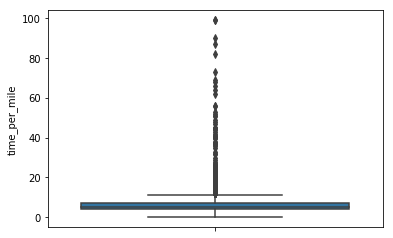

In [68]:
loc_trip_time_distance=loc_pickup_total

loc_trip_time_distance['dropoff_datetime']= pd.to_datetime(loc_trip_time_distance['dropoff_datetime'])
loc_trip_time_distance['pickup_datetime']= pd.to_datetime(loc_trip_time_distance['pickup_datetime'])
ride_time=loc_trip_time_distance['dropoff_datetime'] - loc_trip_time_distance['pickup_datetime']
ride_time=[i.total_seconds()//60 for i in ride_time]
loc_trip_time_distance['ride_time']=ride_time
loc_trip_time_distance['time_per_mile']=loc_trip_time_distance['ride_time']//loc_trip_time_distance['trip_distance']

sns.boxplot(loc_trip_time_distance.time_per_mile,orient='vertical')
loc_trip_time_distance.time_per_mile.describe()


In [69]:
# Being conservative: avg_mins_per_mile>=8
loc_trip_time_distance.loc[loc_trip_time_distance['time_per_mile']>=8,:].shape[0]

1858

bike: 5 mins/mile, walk: 20 mins/mile

**From the time-distance result, we can see the the average taxi ride is 5.75 mins per mile. 50% of the the ride are around 5 mins per mile. Besides, we filter the data that are more than 8 mins per mile and we get 1858 rides. Therefore, there are a lot of chances that people would choose bikes for their commuting tool to save the time when the traffic is bad.**

# Other Visualization

## Seasonality Check

In [70]:
loc_pickup_total['dropoff_datetime']= pd.to_datetime(loc_pickup_total['dropoff_datetime'])
loc_pickup_total['pickup_datetime']= pd.to_datetime(loc_pickup_total['pickup_datetime'])

loc_pickup_total['p_weekday'] = loc_pickup_total.pickup_datetime.dt.weekday_name

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

loc_pickup_total['p_weekday'] = pd.Categorical(loc_pickup_total['p_weekday'], categories=day_order, ordered=True)
loc_pickup_total['p_month'] = loc_pickup_total.pickup_datetime.dt.month
loc_pickup_total['p_day'] = loc_pickup_total.pickup_datetime.dt.day
loc_pickup_total['p_hour'] = loc_pickup_total.pickup_datetime.dt.hour
loc_pickup_total['p_minute'] = loc_pickup_total.pickup_datetime.dt.minute

In [72]:
loc_pickup_total_weekly=loc_pickup_total.groupby(['p_weekday','p_hour'],as_index=False).agg({'pickup_datetime':'count'}).rename(columns={'pickup_datetime':'ride_count'})
loc_pickup_total_weekly=loc_pickup_total_weekly.sort_index()
loc_pickup_total_weekly.head()

,p_weekday,p_hour,ride_count
0,Monday,0,24
1,Monday,1,15
2,Monday,2,14
3,Monday,3,6
4,Monday,4,4


Text(0.5, 0, 'Hour')

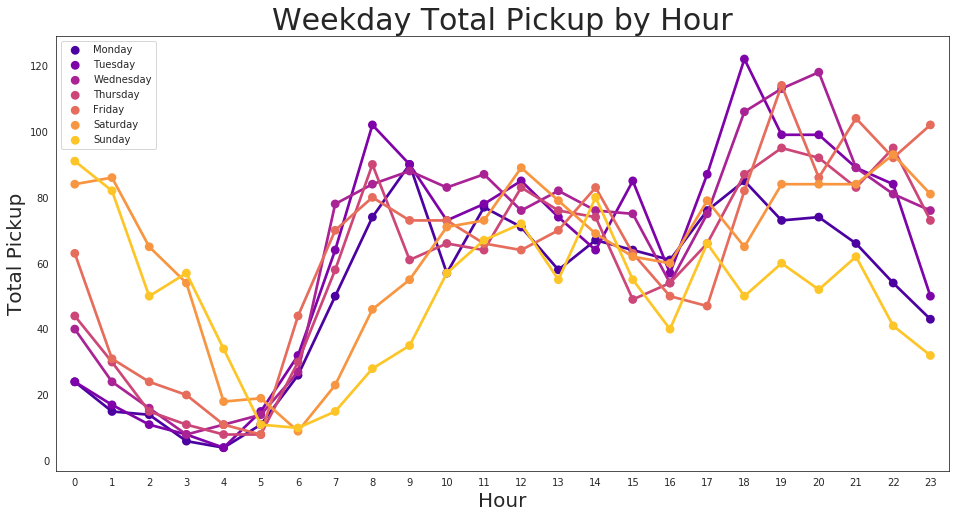

In [78]:
## create figure
sns.set_style("white")
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

## plot data
# sns.pointplot(ax=ax, x='p_weekday',y='ride_count', hue='p_weekday',,linestyles=["-"],
#               palette = current_palette, data = loc_pickup_total_weekly)
sns.pointplot(ax=ax, x='p_hour',y='ride_count',hue='p_weekday',  
         data=loc_pickup_total_weekly, palette = 'plasma')

plt.legend(loc='upper left')

## format plot labels
ax.set_title('Weekday Total Pickup by Hour', fontsize=30)
ax.set_ylabel('Total Pickup', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

**From the above graph, we can see that there are more rides at night and in the morning on the weekdays. On the weekends, more rides happen in the mid-night since more people may go to bars or restaurants at night.**</Br>

**The rides are bimodal distribution due to morning and evening commute.**
